## Chebyshev Polynomial-based KANs

Because turns out B-Splines are actually awful and I hate them

Referencing previous notebooks and this paper https://arxiv.org/html/2405.07200 <br> Also referencing this Cheby KAN implementation https://github.com/SynodicMonth/ChebyKAN

Importing a few libraries...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [2]:
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1/(input_dim * (degree + 1)))

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))  # shape = (batch_size, inputdim)
        # Since Chebyshev polynomial is defined in [-1, 1]
        # We need to normalize x to [-1, 1] using tanh
        x = torch.tanh(x)
        # Initialize Chebyshev polynomial tensors
        cheby = torch.ones(x.shape[0], self.inputdim, self.degree + 1, device=x.device)
        if self.degree > 0:
            cheby[:, :, 1] = x
        for i in range(2, self.degree + 1):
            cheby[:, :, i] = 2 * x * cheby[:, :, i - 1].clone() - cheby[:, :, i - 2].clone()
        # Compute the Chebyshev interpolation
        y = torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)  # shape = (batch_size, outdim)
        y = y.view(-1, self.outdim)
        return y

In [3]:
class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 8, 8)
        self.chebykan2 = ChebyKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x

C:\Users\Colin\AppData\Local\Temp\ipykernel_3184\406201918.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(target_function(x_train.detach().clone()))


Epoch 1/1000, ChebyKAN Loss: 0.4703
Epoch 101/1000, ChebyKAN Loss: 0.0037
Epoch 201/1000, ChebyKAN Loss: 0.0002
Epoch 301/1000, ChebyKAN Loss: 0.0007
Epoch 401/1000, ChebyKAN Loss: 0.0001
Epoch 501/1000, ChebyKAN Loss: 0.0001
Epoch 601/1000, ChebyKAN Loss: 0.0001
Epoch 701/1000, ChebyKAN Loss: 0.0001
Epoch 801/1000, ChebyKAN Loss: 0.0000
Epoch 901/1000, ChebyKAN Loss: 0.0000


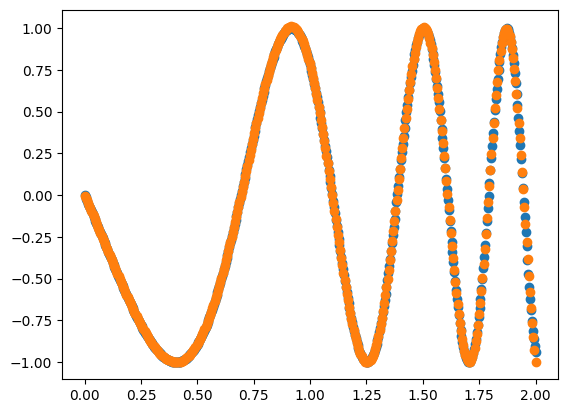

In [4]:
target_function = lambda x: torch.sin(torch.pi * torch.exp(x))

# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train.detach().clone()))

cheby_model = ChebyKAN()
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)

cheby_losses = []

epochs = 1000
for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    loss_cheby.backward()
    optimizer_cheby.step()

    if epoch % 100 == 0:
        cheby_losses.append(loss_cheby.item())
        print(f'Epoch {epoch + 1}/{epochs}, ChebyKAN Loss: {loss_cheby.item():.4f}')

x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_cheby = cheby_model(x_test).detach()
plt.scatter(x_train.numpy(), y_train.numpy())
plt.scatter(x_test.numpy(), y_pred_cheby.numpy())

In [13]:
class CKAN_Layer():

    def __init__(self, dim_in, dim_out, order):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.order = order

        self.coeffs = torch.randn((self.dim_in, self.dim_out, self.order+1), requires_grad=True)

    def forward(self, x_in):

        x_in = torch.reshape(x_in, (-1, self.dim_in))
        x_in = torch.tanh(x_in)
        
        for i in range(self.order+1):
            if i == 0:
                bases = torch.ones(x_in.shape[0], self.dim_in, self.order+1)
    
            elif self.order > 0:
                bases[:, :, 1] = x_in
            else:
                bases[:, :, i] = 2 * x_in * bases[:, :, i-1].clone() - bases[:, :, i-2].clone()

        y_out = torch.einsum('bij, ioj -> bo', bases, self.coeffs)
        y_out = y_out.view(-1, self.dim_out)
        return y_out

    def update(self, learn_rate):
        self.coeffs.data = self.coeffs.data - learn_rate*self.coeffs.grad
        self.coeffs.grad.zero_()
            

In [12]:
class CKAN():
    def __init__(self):
        self.layer1 = CKAN_Layer(1, 8, 8)
        self.layer2 = CKAN_Layer(8, 1, 8)

    def forward(self, x_in):
        y_pred = self.layer1.forward(x_in)
        y_pred = self.layer2.forward(y_pred)
        return y_pred

    def update(self, learn_rate):
        self.layer1.update(learn_rate)
        self.layer2.update(learn_rate)

torch.Size([1000, 1])
Epoch 0, loss: 203.4610595703125
Epoch 100, loss: 0.47701308131217957
Epoch 200, loss: 0.34629175066947937
Epoch 300, loss: 0.2880932688713074
Epoch 400, loss: 0.2847530245780945
Epoch 500, loss: 0.28302815556526184
Epoch 600, loss: 0.2816004157066345
Epoch 700, loss: 0.2803436517715454
Epoch 800, loss: 0.27918919920921326
Epoch 900, loss: 0.27809858322143555
Epoch 1000, loss: 0.2770506739616394
Epoch 1100, loss: 0.2760336101055145
Epoch 1200, loss: 0.27503976225852966
Epoch 1300, loss: 0.27406376600265503
Epoch 1400, loss: 0.27310070395469666
Epoch 1500, loss: 0.2721463143825531
Epoch 1600, loss: 0.2711959779262543
Epoch 1700, loss: 0.2702450156211853
Epoch 1800, loss: 0.26928818225860596
Epoch 1900, loss: 0.26831960678100586
Epoch 2000, loss: 0.26733270287513733
Epoch 2100, loss: 0.2663195729255676
Epoch 2200, loss: 0.2652708888053894
Epoch 2300, loss: 0.2641748785972595
Epoch 2400, loss: 0.26301705837249756
Epoch 2500, loss: 0.26177850365638733
Epoch 2600, loss

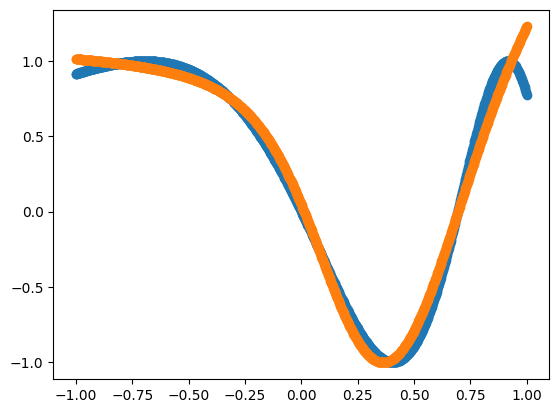

In [21]:
fn_target = lambda x: torch.sin(torch.pi * torch.exp(x))

x_eval = torch.linspace(-1, 1, steps=1000).unsqueeze(1)
y_target = fn_target(x_eval)
learn_rate = 0.01

Model = CKAN()
#loss_fn = nn.MSELoss()
#optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)

print(y_target.shape)
for epoch in range (20000):
    
    y_pred = Model.forward(x_eval)
    loss = torch.mean(torch.pow(y_pred - y_target, 2))
    loss.backward()
    Model.update(learn_rate)

    if not (epoch % 100):
        print(f"Epoch {epoch}, loss: {loss.item()}")
    
plt.scatter(x_eval, y_target)
plt.scatter(x_eval, y_pred.detach())